<a href="https://colab.research.google.com/github/SofiaFreiman/Lung_epitelium/blob/main/PP_QC_Batch_Anno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scanpy leidenalg scikit-misc bbknn celltypist scvi scrublet
import os
os.kill(os.getpid(), 9)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import os
import pandas as pd
import numpy as np
import scipy.stats
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.external as sce
import anndata
import celltypist

sc.settings.verbosity = 1
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

In [ ]:
path = "drive/MyDrive/LU/Pavan_data/"

In [ ]:
adata = sc.read(path + "adata_doublet_filtered.h5ad")
adata.X = adata.layers['counts'].copy()
print(adata.X.max())

30844.0


#### QC Filtering

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['ribo'] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], percent_top=[20], log1p=False, inplace=True)

In [ ]:
# Plot descriptive plots for the dataset
def qc(adata):
  fig, axs = plt.subplots(ncols = 6, nrows = 1, figsize = (24, 4), layout = "constrained")

  sns.distplot(adata.obs['total_counts'], kde = False, ax = axs[0], hist_kws={"alpha":1}, color = 'g', bins = 100)
  axs[0].set_xlabel("n UMI per cell (total counts)", fontsize = 10); axs[0].set_ylabel('n cells', fontsize = 10);
  axs[0].set_xlim(0, 80000); axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))

  sns.distplot(adata.obs['n_genes_by_counts'], kde = False, ax = axs[1], hist_kws={"alpha":1}, color = 'b')
  axs[1].set_xlabel("n genes per cell", fontsize = 10); axs[1].set_ylabel('n cells', fontsize = 10);
  axs[1].set_xlim(0, 10000)

  sns.scatterplot(y = adata.obs["n_genes_by_counts"], x = adata.obs["total_counts"], ax=axs[2], s = 3, color = 'goldenrod')
  axs[2].set_xlabel("n UMI per cell (total counts)", fontsize = 10); axs[2].set_ylabel("n genes per cell", fontsize = 10)
  axs[2].xaxis.set_major_locator(plt.MaxNLocator(3))

  sns.distplot(adata.obs["pct_counts_mt"], kde = False, ax = axs[3], hist_kws={"alpha":1}, color = 'firebrick', bins = 100)
  axs[3].set_xlabel("% of mt expression", fontsize = 10); axs[3].set_ylabel('n cells', fontsize = 10)
  axs[3].set_xlim(0, 50)

  sns.distplot(adata.obs["pct_counts_ribo"], kde = False, ax = axs[4], hist_kws={"alpha":1}, color = 'firebrick', bins = 100)
  axs[4].set_xlabel("% of ribo expression", fontsize = 10); axs[4].set_ylabel('n cells', fontsize = 10)
  axs[4].set_xlim(0, 50)

  sns.distplot(adata.obs["pct_counts_hb"], kde = False, ax = axs[5], hist_kws={"alpha":1}, color = 'firebrick')
  axs[5].set_xlabel("% of hb expression", fontsize = 10); axs[5].set_ylabel('n cells', fontsize = 10)
  axs[5].set_xlim(0, 50)

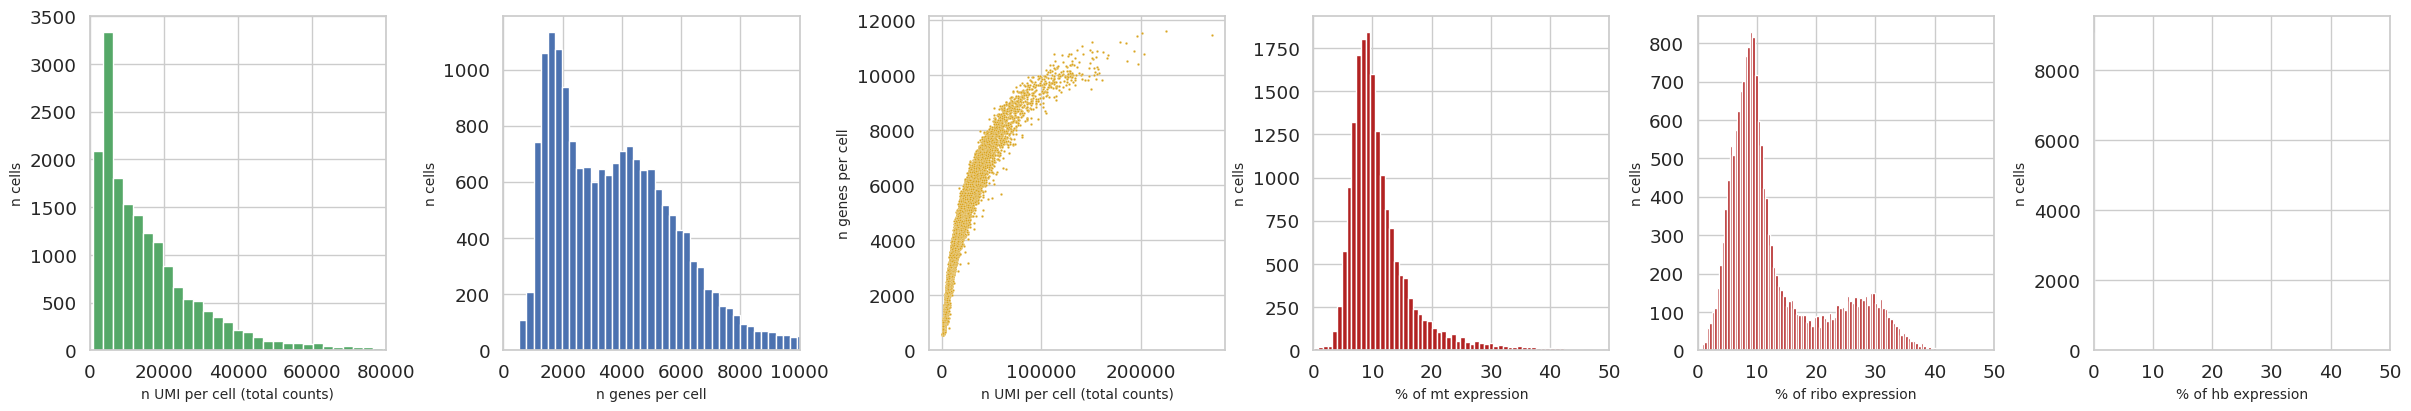

In [ ]:
qc(adata)

In [ ]:
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", 5) | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5))
adata.obs.outlier.value_counts()

outlier
False    17204
True       582
Name: count, dtype: int64

In [ ]:
adata.obs['tmp'] = (((adata.obs['anno'] != "Ionocytes") & (adata.obs['pct_counts_mt'] > 12)) | (adata.obs['outlier'] == True))
print(adata.obs['tmp'].value_counts())
adata = adata[adata.obs['tmp'] == False]

tmp
False    12490
True      5296
Name: count, dtype: int64


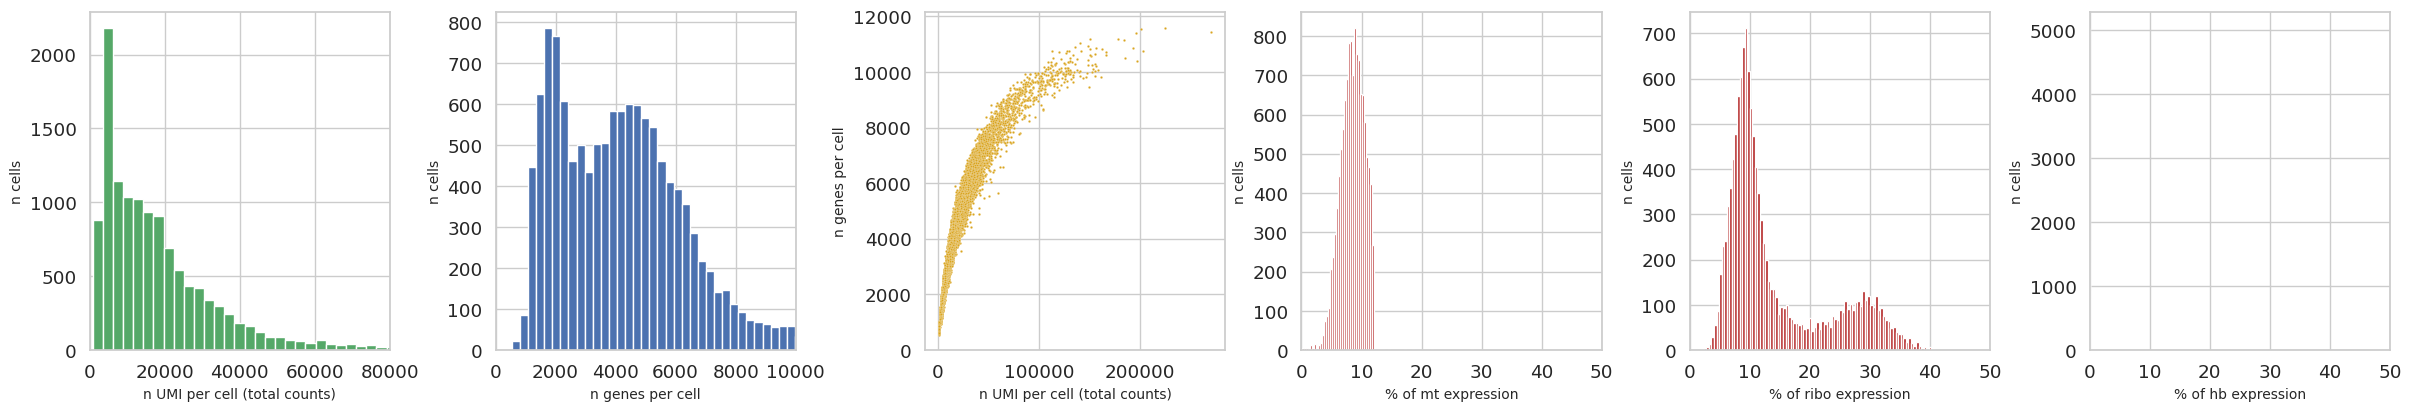

In [ ]:
qc(adata)

#### Batch correction and Normalization

In [ ]:
ribo = adata.var.index.str.startswith(("RPS", "RPL"))
mt = adata.var.index.str.startswith('MT-')

adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["lognorm"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, n_top_genes = 2500, layer = "counts", flavor = "seurat_v3")
adata.var.loc[adata.var["mt"] | adata.var["ribo"], "highly_variable"] = False
sc.pp.pca(adata, use_highly_variable = True)
sce.pp.bbknn(adata, batch_key = 'sname')
sc.tl.umap(adata, min_dist = 0.4, random_state = 0, n_components=2)

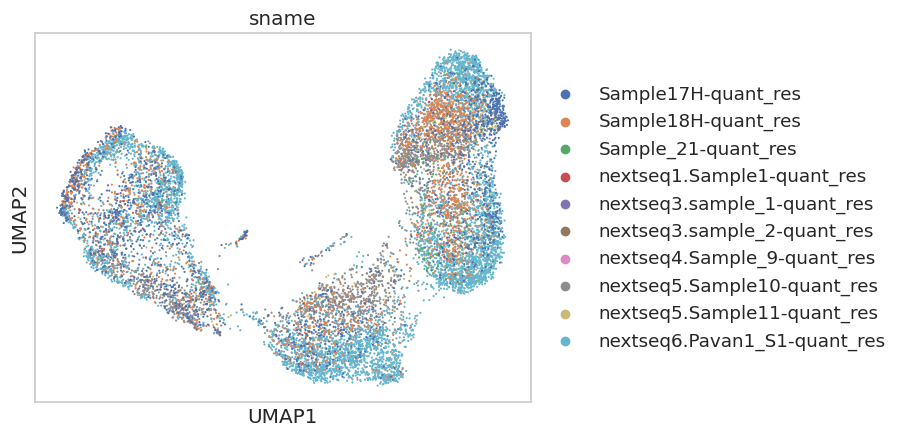

In [ ]:
sc.pl.umap(adata, color = 'sname')

#### Cell cycle score and Annotation

In [ ]:
## Cell cycle

!curl -o cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt
cell_cycle_genes = [x.strip() for x in open('cell_cycle_genes.txt')]
cell_cycle_genes = [i for i in cell_cycle_genes if i in adata.var.index]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
adata.var_names_make_unique()
sc.tl.score_genes_cell_cycle(adata, s_genes = s_genes, g2m_genes = g2m_genes)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   556  100   556    0     0   7186      0 --:--:-- --:--:-- --:--:--  7220


In [ ]:
adata.X.max()

np.float32(8.334516)

In [ ]:
## Celltypist annotation

from celltypist import models
models.download_models(force_update = True)
model_1 = 'Human_Lung_Atlas.pkl'
model_2 =  'Human_IPF_Lung.pkl'

# adata.layers["counts"] = adata.X.copy()
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes = 2500, layer = "counts", flavor = "seurat_v3")
# sc.pp.pca(adata, use_highly_variable = True)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
for model, name in zip([model_1, model_2], ["LungAtlas", "IPF_Lung"]):
  predictions = celltypist.annotate(adata, model = model, majority_voting = True)
  pred_adata = predictions.to_adata()
  adata.obs["celltypist_pred_coarse_labels_model_" + name]  = pred_adata.obs["predicted_labels"]
  adata.obs["celltypist_pred_coarse_voting_model_" + name] = pred_adata.obs["majority_voting"]
  adata.obs["celltypist_pred_coarse_conf_score_model_" + name] = pred_adata.obs["conf_score"]
  del predictions
  del pred_adata
adata.layers["counts"] = adata.X.copy()

In [ ]:
for col in adata.obs.columns:
  if "leiden" in col:
    del adata.obs[col]
for res in [0.5, 1, 1.5, 2]:
  sc.tl.leiden(adata, resolution = res, key_added = "leiden_" + str(res))

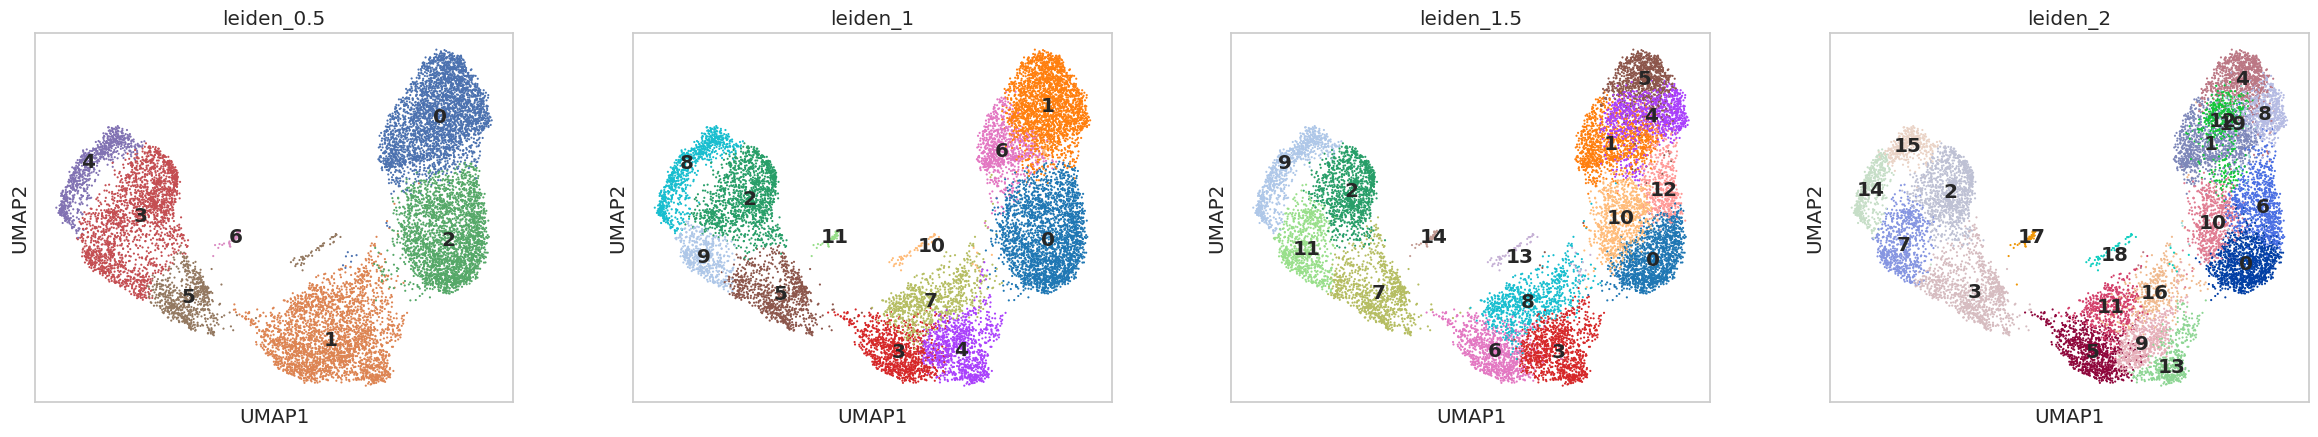

In [ ]:
sc.pl.umap(adata, color = [i for i in adata.obs.columns if "leiden" in i], ncols = 4, legend_loc = 'on data')

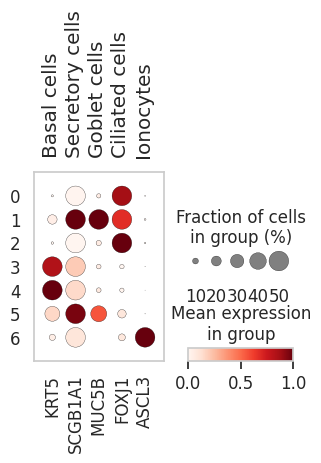

In [ ]:
cell_dict = {'Basal cells' : 'KRT5',
             'Secretory cells' : 'SCGB1A1',
             'Goblet cells' : 'MUC5B',
             'Ciliated cells' : 'FOXJ1',
             'Ionocytes' : 'ASCL3',
}

sc.pl.dotplot(adata, cell_dict, groupby="leiden_0.5", dendrogram=False, dot_max=0.5, standard_scale="var")

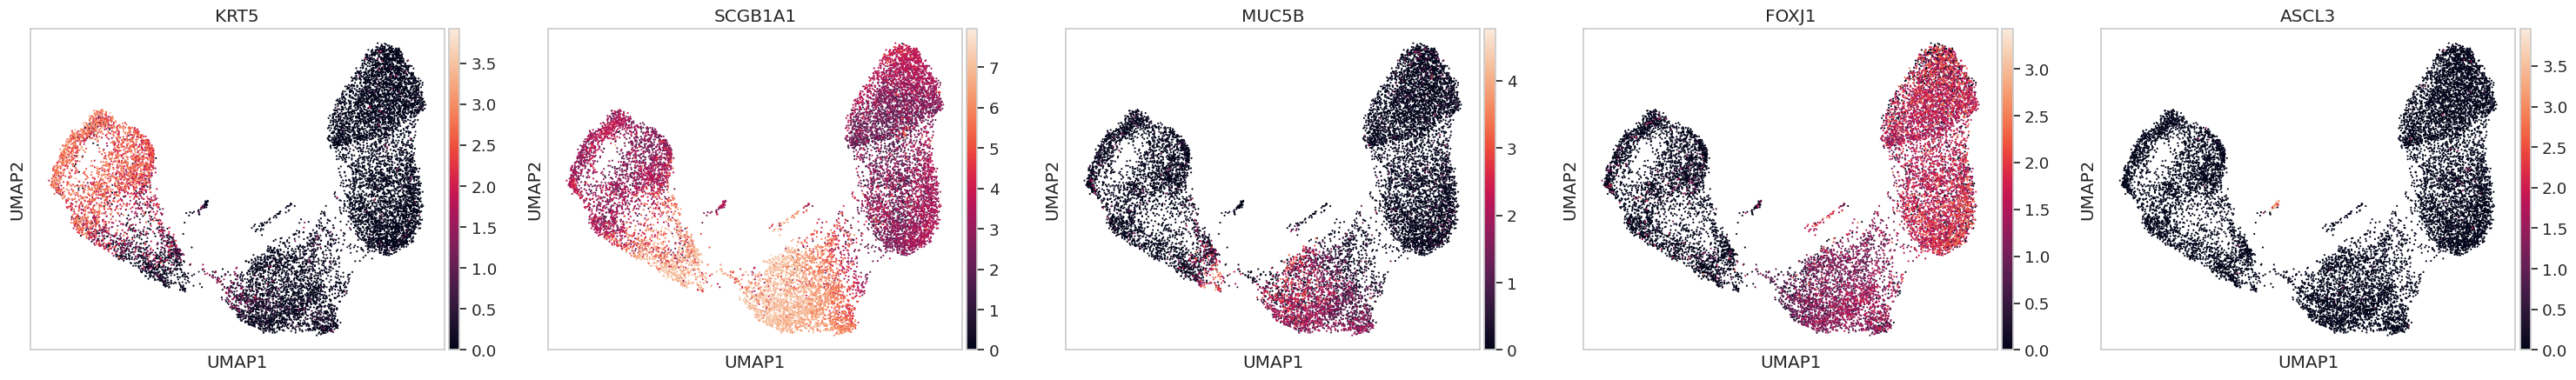

In [ ]:
sc.pl.umap(adata, color = cell_dict.values(), ncols = 5)

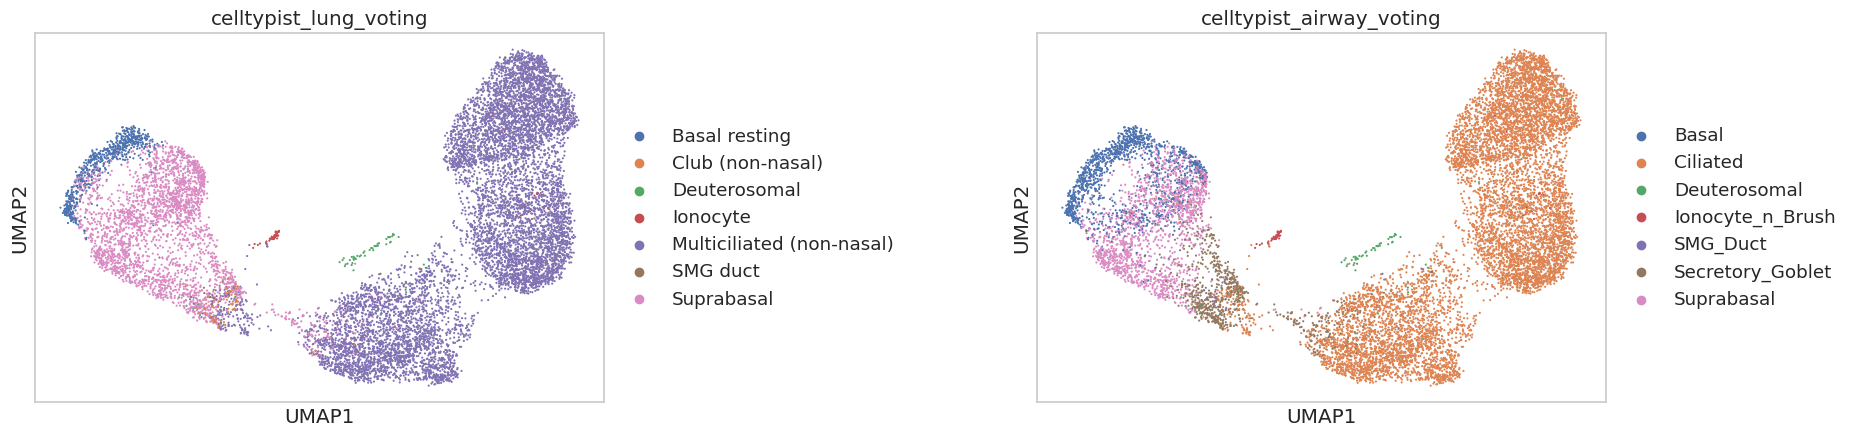

In [ ]:
sc.pl.umap(adata, color = ['celltypist_lung_voting', "celltypist_airway_voting"], wspace = 0.6)

In [ ]:
## Manual annotation based on leiden-0.5 clustering

leiden_to_ct = {
    '0' : "Multi-ciliated cells 2",
    "1" : "Secretory cells",
    "2" : "Multi-ciliated cells 1",
    "3" : "Suprabasal cells",
    "4" : "Basal cells",
    "5" : "Goblet cells",
    "6" : "Ionocytes",
}
adata.obs['anno_l3'] = [leiden_to_ct[i] for i in adata.obs["leiden_0.5"]]
adata.obs['anno_l3'] = adata.obs['anno_l3'].copy().astype("category")
adata.obs['anno_l3'] = adata.obs['anno_l3'].cat.add_categories(["Deuterosomal cells"])
adata.obs['anno_l2'] = adata.obs['anno'].copy()

## Fine correction
for i in adata.obs.index:
  for s in ['10']:
    if adata.obs.loc[i, 'leiden_1'] == s:
      adata.obs.loc[i, 'anno_l3'] = "Deuterosomal cells"

adata.obs['anno_l2'] = adata.obs['anno_l3'].replace({"Multi-ciliated cells 1" : "Ciliated cells", "Multi-ciliated cells 2" : "Ciliated cells"})
adata.obs['anno_l1'] = adata.obs['anno_l2'].replace({"Basal cells" : "Basal-to-Goblet cells", "Suprabasal cells" : "Basal-to-Goblet cells", "Goblet cells" : "Basal-to-Goblet cells"})
adata.obs['anno_l2'] = adata.obs['anno_l2'].cat.remove_unused_categories()
adata.obs['anno_l1'] = adata.obs['anno_l1'].cat.remove_unused_categories()
print(set(adata.obs['anno_l3'])); print(set(adata.obs['anno_l2'])); print(set(adata.obs['anno_l1']))

{'Ionocytes', 'Secretory cells', 'Deuterosomal cells', 'Goblet cells', 'Basal cells', 'Suprabasal cells', 'Multi-ciliated cells 2', 'Multi-ciliated cells 1'}
{'Ionocytes', 'Secretory cells', 'Deuterosomal cells', 'Ciliated cells', 'Goblet cells', 'Basal cells', 'Suprabasal cells'}
{'Ionocytes', 'Secretory cells', 'Deuterosomal cells', 'Basal-to-Goblet cells', 'Ciliated cells'}


In [ ]:
l1_colors = {'Basal-to-Goblet cells': 'tab:blue', 'Ciliated cells': 'tab:green', 'Secretory cells': 'tab:orange', 'Ionocytes': 'orangered', 'Deuterosomal cells': 'deeppink'}
l2_colors = {'Basal cells': 'tab:green', 'Suprabasal cells': 'darkseagreen', 'Goblet cells': 'mediumaquamarine', 'Secretory cells': 'burlywood', 'Ciliated cells': 'mediumpurple', 'Ionocytes': 'orangered', 'Deuterosomal cells': 'deeppink'}
l3_colors = {'Basal cells' : "tab:green", 'Suprabasal cells' : "darkseagreen", "Goblet cells" : "mediumaquamarine", "Secretory cells" : "burlywood",
             "Multi-ciliated cells 1" : "cornflowerblue", "Multi-ciliated cells 2" : "mediumpurple", "Ionocytes" : "orangered", "Deuterosomal cells" : "deeppink"}

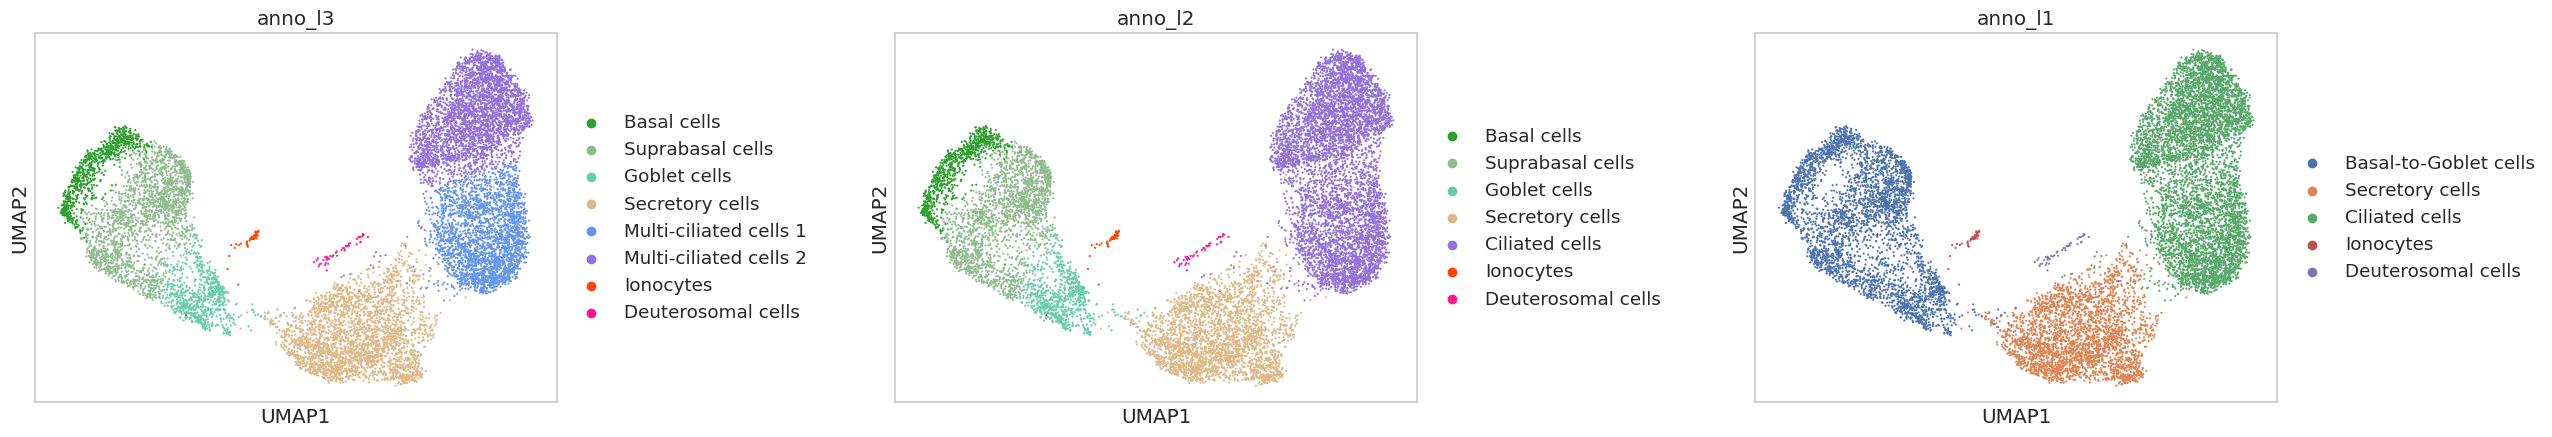

In [ ]:
sc.pl.umap(adata, color = ['anno_l3', 'anno_l2', 'anno_l1'], wspace = 0.5)

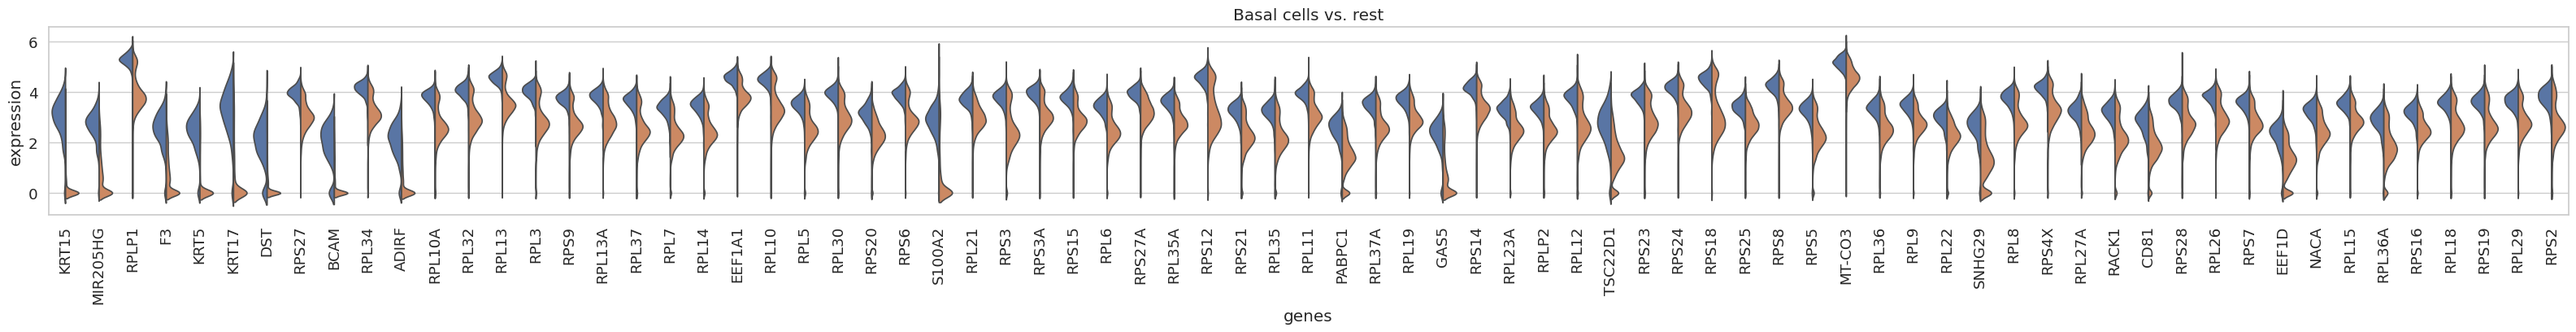

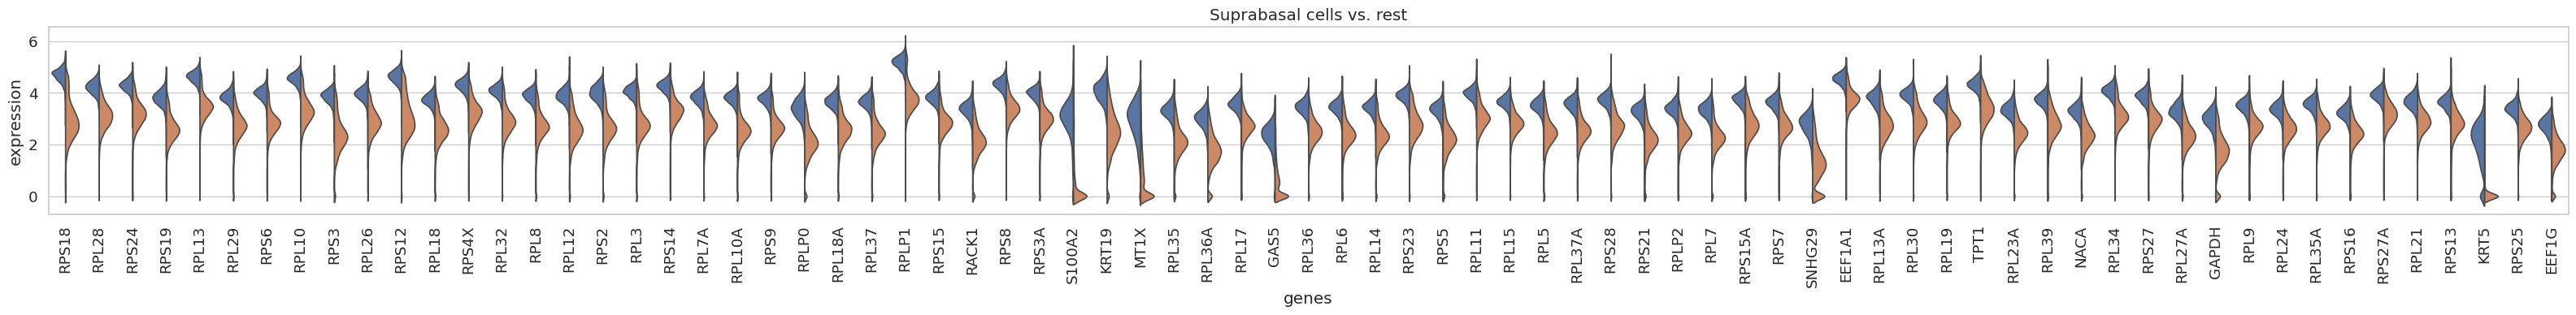

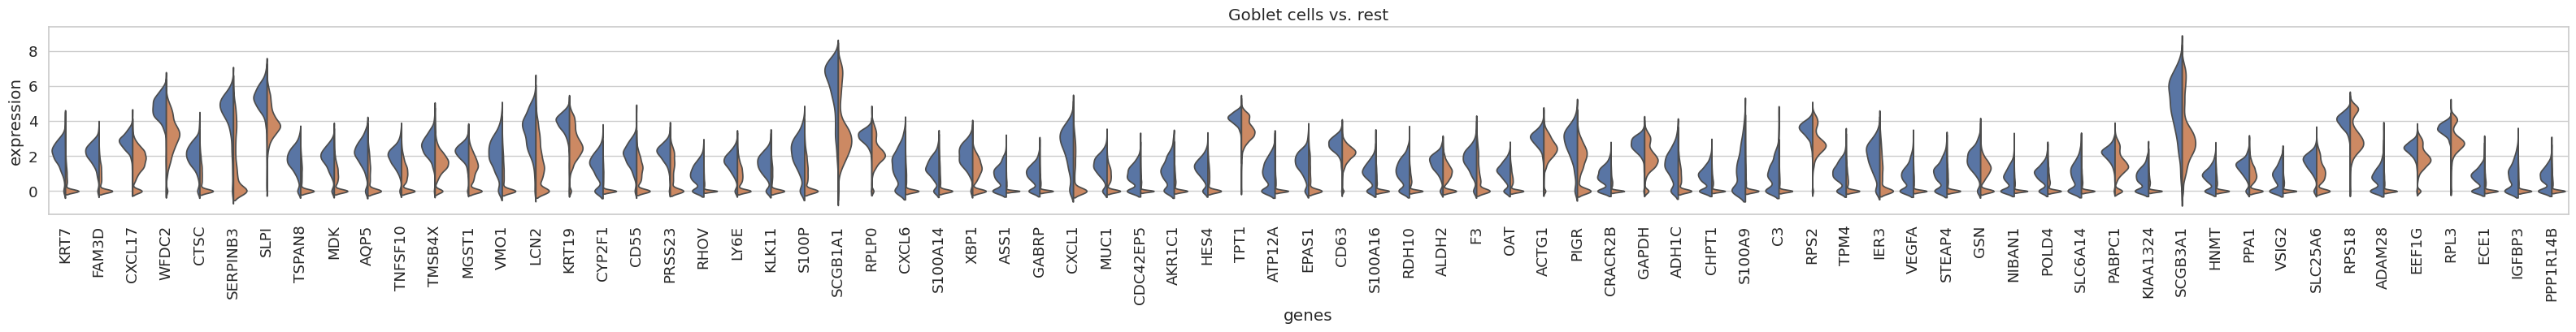

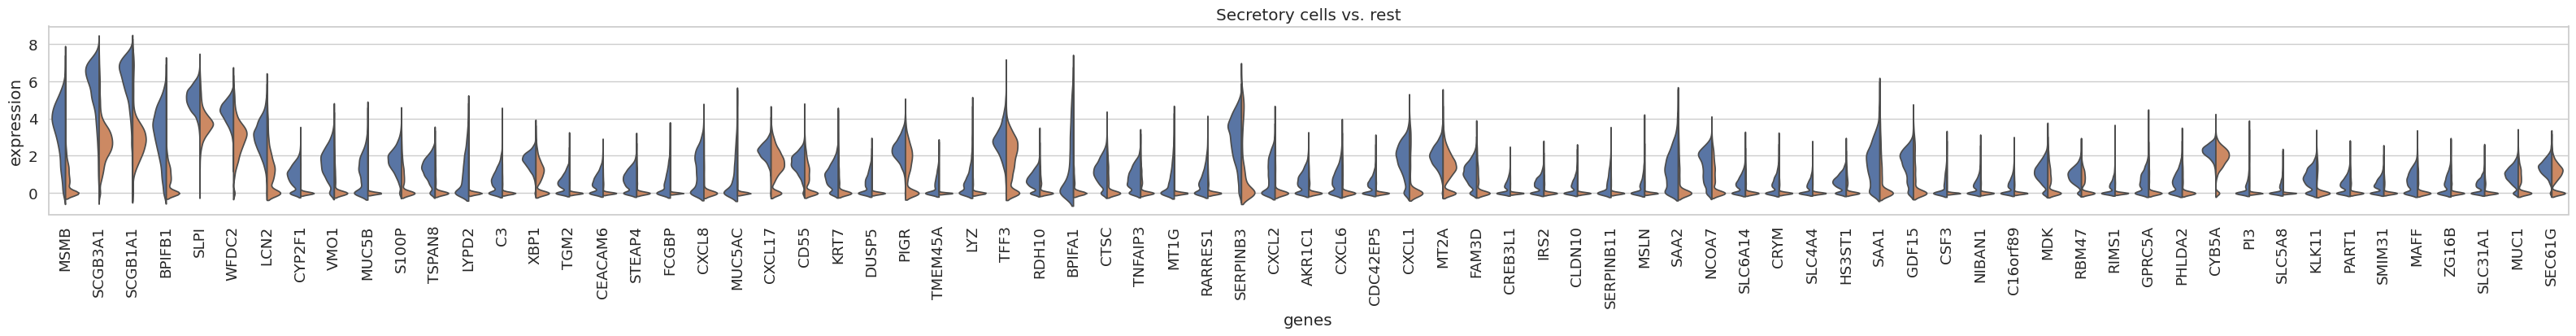

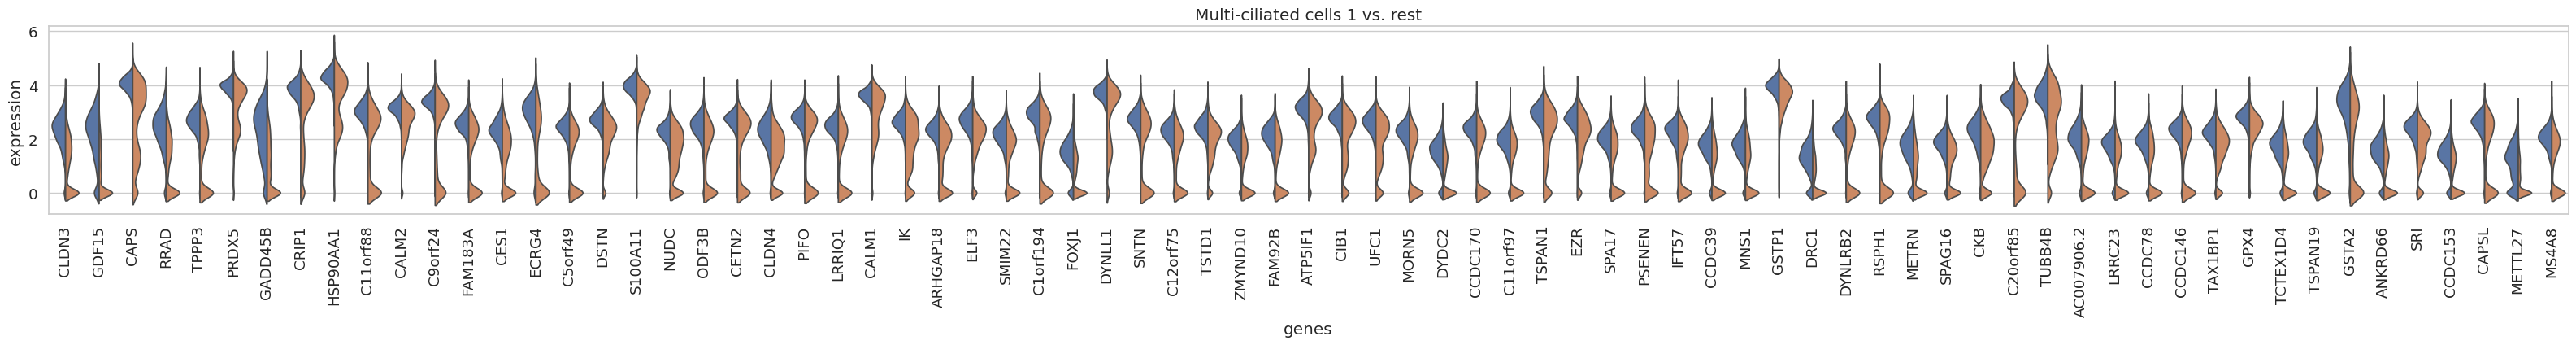

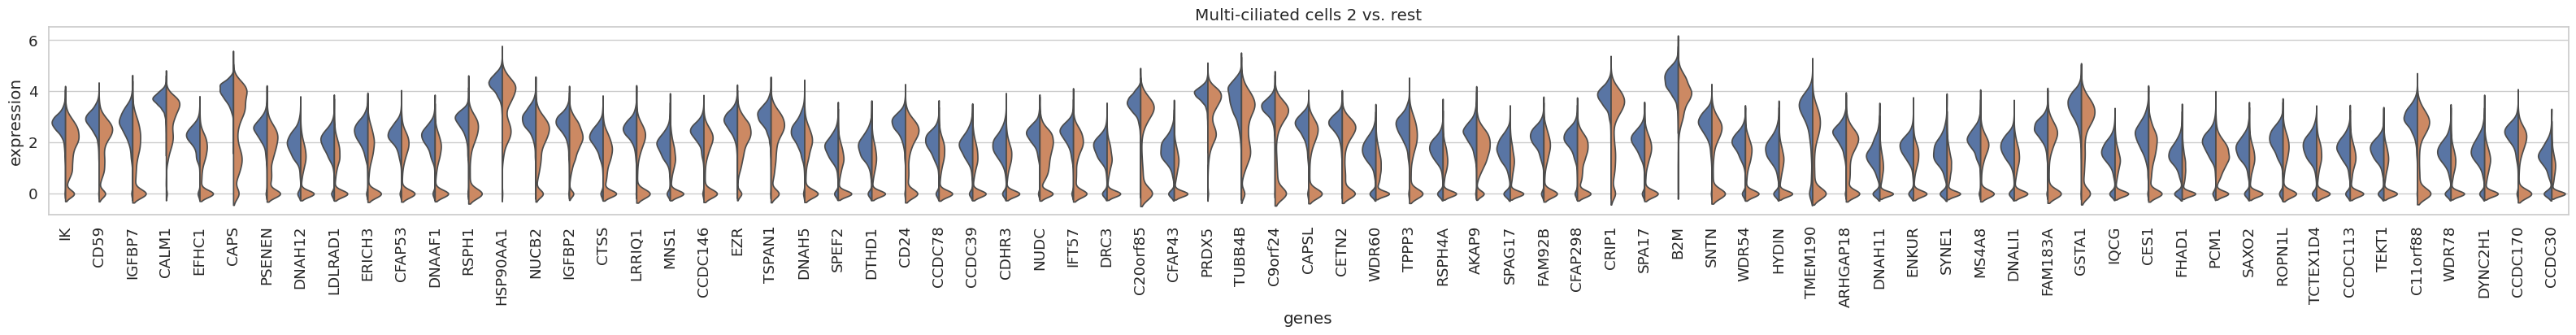

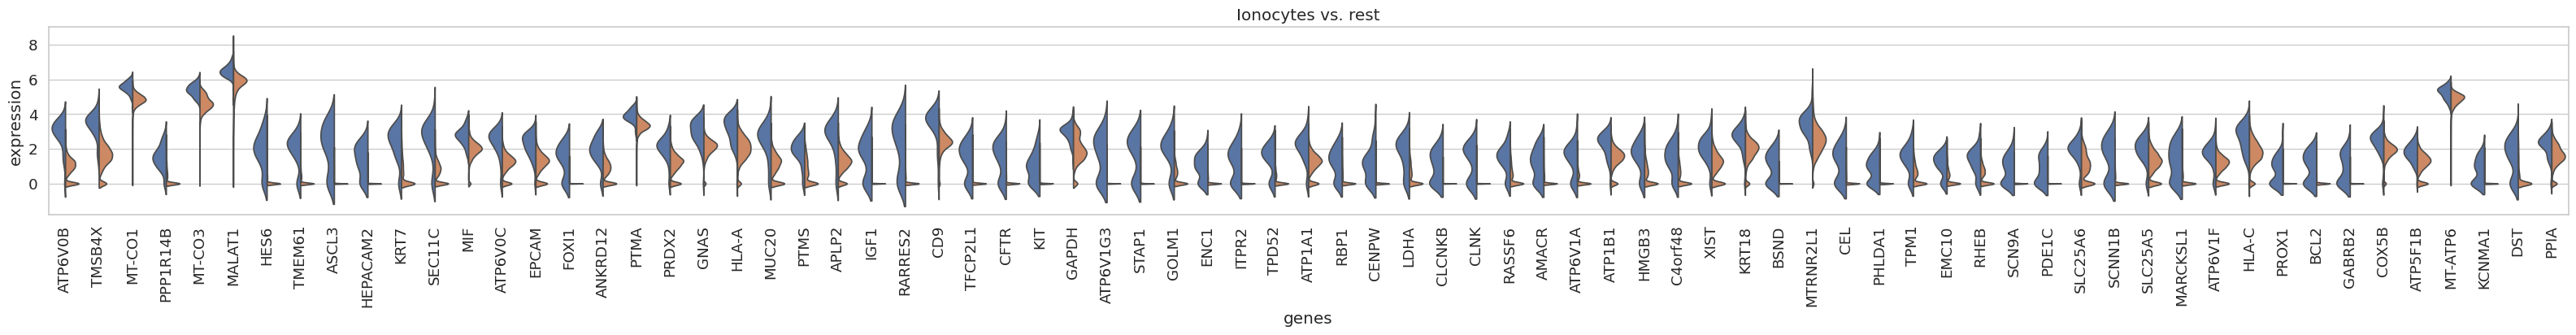

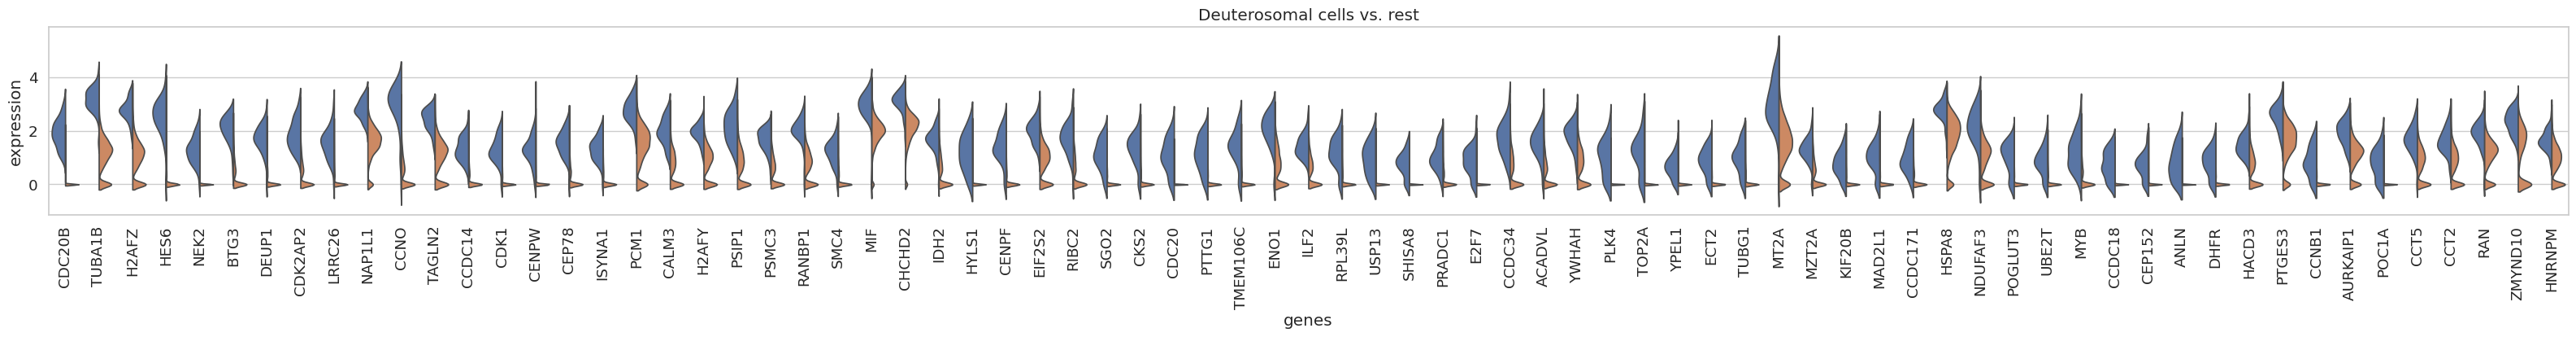

In [ ]:
## Display top-genes accounting to each cell type
sc.tl.rank_genes_groups(adata, 'anno_l3', method='wilcoxon', key_added = "wilcoxon_ct")

from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (40, 3)}):
    sc.pl.rank_genes_groups_violin(adata, n_genes=75, strip=False, key = 'wilcoxon_ct')

## Versions

In [2]:
!python --version

Python 3.11.12


In [3]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.6.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.6
ale-py                                0.11.0
altair                                5.5.0
anndata                               0.11.4
annotated-types                       0.7.0
annoy                                 1.17.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_api_compat                      1.11.2
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.0.1
astrop